# Match tensor v3 

In [1]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten
from keras.layers.pooling import GlobalMaxPooling2D
from keras.models import Model
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed

Using TensorFlow backend.


In [2]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec.model'
vocab_path='model/word2vec_vocab.json'
embeddings_path='model/embeddings.npz'

In [3]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term']


In [4]:
#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')

In [5]:
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

In [6]:

train_query_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")
#,stopwords,stemming
#"spelling,nonascii" no diff.

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 6 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
search_term      74067 non-null object
relevance        74067 non-null float64
relevance_int    74067 non-null int64
product_idx      74067 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB
None


In [7]:
test_private_df = HomeDepotFeature().getFeature(test_private_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78419 entries, 2 to 147405
Data columns (total 4 columns):
id             78419 non-null int64
product_uid    78419 non-null int64
search_term    78419 non-null object
relevance      78419 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ MB
None


In [8]:
test_public_df = HomeDepotFeature().getFeature(test_public_df, product_df, attribute_df, test_public_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.0 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33648 entries, 1 to 147404
Data columns (total 4 columns):
id             33648 non-null int64
product_uid    33648 non-null int64
search_term    33648 non-null object
relevance      33648 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB
None


In [9]:
# product_df['content'] = train_query_df['search_term'].map(str) + " " + \
#                         product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) + " " + \
#                         product_df['attr_json'].map(str)

product_df['content'] = product_df['product_title'].map(str) + " " + \
                        product_df['product_description'].map(str) 

# ## no attribute
# product_df['content'] = product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) 
        
#product_df['content']

In [10]:
len(test_public_df)

33648

In [39]:
#https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors
def doc_to_wordlist( doc, vocab=['<PAD>', '<OOV>'], remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    #review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    if remove_non_letters:
        doc = re.sub("[^a-zA-Z]"," ", doc)
    # 2a. remove non-letters, numbers
    if remove_non_letters_numbers:
        doc = re.sub("[^a-zA-Z0-9]"," ", doc)
    #
    # 3. Convert words to lower case and split them
    words = doc.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        #words = [w for w in words if not w in stops]
        new_words = []
        for w in words:
            if not w in stops:
                new_words.append(w)
                #if w not in vocab: #TODO: temp removal, too slow
                #    vocab.append(w)
    
    # 5. Return a list of words
    return new_words,vocab

# words,vocab=doc_to_wordlist(product_df['content'][0],remove_stopwords=True, remove_non_letters=False, remove_non_letters_numbers=True)
# print(len(words),len(vocab))
# print(vocab)
# words,vocab=doc_to_wordlist(product_df['content'][0],remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True)
# print(len(words),len(vocab))
# print(vocab)
# product_df['content'][0]

In [40]:
# # Download the punkt tokenizer for sentence splitting
import nltk.data
# nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [41]:
### tokenisation
class alt_tokenizer():
    def alt_tokenize(sentence):
        token = re.compile("[\w]+(?=n't)|n't|\'s|\'m|\'ll|[\w]+|[.?!;,\-\(\)—\:'\"]")
        return token.findall(sentence)

#load alt tokenizer
my_alt_tokenizer = alt_tokenizer()

In [42]:
# Define a function to split a doc into parsed sentences
def doc_to_sentences( doc, tokenizer, vocab=None, remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True ):
    if vocab is None:
        vocab = ['<PAD>', '<OOV>']
    
    # Function to split a doc into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(doc.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            (words,vocab) = doc_to_wordlist( raw_sentence, vocab, remove_stopwords )
            sentences.append(words)
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences,vocab


In [43]:
print(product_df['product_description'][100])
print(product_df['content'][100])
vocab=['<PAD>', '<OOV>']
words,vocab=doc_to_wordlist(product_df['content'][100],remove_stopwords=True, \
                            remove_non_letters=False, remove_non_letters_numbers=True)
print(len(words))
#print(len(doc_to_wordlist(product_df['content'][0],remove_stopwords=False)))
print(len(vocab))
print(vocab)

the pc600 pelican premium 10 gpm whole house carbon water filter system for homes with 1 3 bathrooms is a deluxe high capacity virtually maintenance free system that is easily installed in any home and has a 600 000 5 year capacity only the top rated valves and tanks are used in manufacturing each pelican system backed by an industry leading limited life time parts warranty imagine spring like water through every faucet of your home drink bathe and shower in sparkling clean water with no more dry itchy skin or unpleasant odors from chemicals the large diameter of the tank holds a significant amount of water filtration carbon media increasing the overall performance and life span and the replacement cost is a fraction of the cost of similar items when it comes time to replace the filter all you have to do is replace the media inside the tank with no plumbing required and no need to replace the entire tank wrapped in premium stainless steel to ensure long life durability and unsurpassed 

In [44]:
product_df['content'][100]
vocab=None
sentences,vocab = doc_to_sentences(product_df['content'][100],tokenizer,remove_stopwords=True, \
                            remove_non_letters=False, remove_non_letters_numbers=True)
print(len(sentences))
print(len(vocab))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=True)))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=False)))
# product_df['content'][0]

1
2


In [45]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []
vocab=['<PAD>', '<OOV>']
print("Parsing sentences from search string")
for query in train_query_df["search_term"]:
    words,vocab=doc_to_wordlist(query,vocab, remove_stopwords=True, remove_non_letters=False, remove_non_letters_numbers=True)
    query_sentences += [words]
 

Parsing sentences from search string


In [46]:
print(len(query_sentences))
print(len(vocab))

74067
2


In [47]:
print("Parsing sentences from unlabeled set")
for doc in product_df['content']:
    words,vocab=doc_to_wordlist(doc,vocab, remove_stopwords=True,remove_non_letters=False, remove_non_letters_numbers=True)
    doc_sentences += [words]

sentences = query_sentences+doc_sentences   

Parsing sentences from unlabeled set


In [48]:
print(len(sentences))
print(len(vocab))

198495
2


In [49]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 0 #1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
word2vec_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
word2vec_model.save(word2vec_model_path)

2017-04-04 17:44:42,913 : INFO : collecting all words and their counts
2017-04-04 17:44:42,926 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-04 17:44:42,942 : INFO : PROGRESS: at sentence #10000, processed 29172 words, keeping 3572 word types
2017-04-04 17:44:42,956 : INFO : PROGRESS: at sentence #20000, processed 59500 words, keeping 4877 word types
2017-04-04 17:44:42,971 : INFO : PROGRESS: at sentence #30000, processed 89924 words, keeping 5430 word types
2017-04-04 17:44:42,984 : INFO : PROGRESS: at sentence #40000, processed 119667 words, keeping 5752 word types
2017-04-04 17:44:42,998 : INFO : PROGRESS: at sentence #50000, processed 149568 words, keeping 6001 word types
2017-04-04 17:44:43,012 : INFO : PROGRESS: at sentence #60000, processed 183701 words, keeping 6510 word types
2017-04-04 17:44:43,029 : INFO : PROGRESS: at sentence #70000, processed 220154 words, keeping 6767 word types


Training model...


2017-04-04 17:44:43,194 : INFO : PROGRESS: at sentence #80000, processed 932103 words, keeping 25318 word types
2017-04-04 17:44:43,437 : INFO : PROGRESS: at sentence #90000, processed 2064512 words, keeping 38929 word types
2017-04-04 17:44:43,684 : INFO : PROGRESS: at sentence #100000, processed 3187550 words, keeping 48854 word types
2017-04-04 17:44:43,934 : INFO : PROGRESS: at sentence #110000, processed 4289312 words, keeping 56824 word types
2017-04-04 17:44:44,179 : INFO : PROGRESS: at sentence #120000, processed 5411786 words, keeping 64406 word types
2017-04-04 17:44:44,461 : INFO : PROGRESS: at sentence #130000, processed 6515745 words, keeping 70725 word types
2017-04-04 17:44:44,768 : INFO : PROGRESS: at sentence #140000, processed 7592124 words, keeping 77066 word types
2017-04-04 17:44:45,058 : INFO : PROGRESS: at sentence #150000, processed 8675235 words, keeping 82516 word types
2017-04-04 17:44:45,330 : INFO : PROGRESS: at sentence #160000, processed 9753858 words, ke

In [50]:
print(len(word2vec_model.wv.vocab))
#word2vec_model.wv.vocab

104590


In [51]:
print(word2vec_model.most_similar('wood', [], 3))
#print(word2vec_model.most_similar('temperature'))

[('hardwood', 0.6149548888206482), ('hardwoods', 0.5928762555122375), ('pine', 0.5321435332298279)]


In [52]:
# #w2v=Feature_Word2Vec(modelFilename=word2vec_model_path)#modelFilename=word2vec_model_path
# w2v=Feature_Word2Vec()
# #sentences=w2v.convertDFIntoSentences(product_df,'content')
# #print(sentences)
# w2v.trainModel(sentences)

In [53]:
# len(w2v.model.wv.vocab)

In [54]:
# w2vExpand=Word2VecQueryExpansion(modelFilename=word2vec_model_path)
# query="cooking"
# print("Expanding query: ")
# print(w2vExpand.getExpandedQuery(query,maxNoOfAdditionalWords=2,minSimilarityLevel=0.65,))

In [55]:
# print(w2v.getVectorFromWord('wood'))
# print(w2v.getSimilarWordVectors('wood',5))
# print(len(w2v.getVectorFromWord('wood')))

# embeddings to keras
http://ben.bolte.cc/resources/embeddings/embeddings.html

In [56]:
#vocab = dict([(k, v.index) for k, v in w2v.model.wv.vocab.items()])
#vocab = dict([(k, v.index) for k, v in word2vec_model.wv.vocab.items()])
word2vec_vocab = dict([(k, v.index+2) for k, v in word2vec_model.wv.vocab.items()]) # Leave room for <pad>
word2vec_vocab['<PAD>']=0
word2vec_vocab['<OOV>']=1
with open(vocab_path, 'w') as f:
    f.write(json.dumps(word2vec_vocab))

In [57]:
#weights = w2v.model.wv.syn0
weights = word2vec_model.wv.syn0
np.save(open(embeddings_path, 'wb'), weights)

In [58]:
def load_vocab(vocab_path):
    """
    Load word -> index and index -> word mappings
    :param vocab_path: where the word-index map is saved
    :return: word2idx, idx2word
    """

    with open(vocab_path, 'r') as f:
        data = json.loads(f.read())
    word2idx = data
    idx2word = dict([(v, k) for k, v in data.items()])
    return word2idx, idx2word

In [59]:
word2idx, idx2word = load_vocab(vocab_path)

In [60]:
def word2vec_embedding_layer(embeddings_path):
    """
    Generate an embedding layer word2vec embeddings
    :param embeddings_path: where the embeddings are saved (as a numpy file)
    :return: the generated embedding layer
    """

    saved_weights = np.load(open(embeddings_path, 'rb'))
    padding_weight = np.zeros(num_features)
    padding_weight=np.expand_dims(padding_weight,axis=0)
    oov_weight = np.random.rand(num_features)
    oov_weight=np.expand_dims(oov_weight,axis=0)    
    weights=np.concatenate((padding_weight,saved_weights), axis=0)
    layer = Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights],mask_zero=True, trainable=False)
    return layer

In [61]:
# a = np.load(open(embeddings_path, 'rb'))
# b = np.zeros(50)
# b=np.expand_dims(b,axis=0)
# b.shape

In [62]:
# c=np.concatenate((b,a), axis=0)
# c[0:2]

In [63]:
# idx2word = []
# idx2word=[dict([(v, k) for k, v in word2idx.items()])]
# idx2word.insert(0, '<PAD>')

In [64]:
idx2word[0]

'<PAD>'

In [65]:
idx2word[1]

'<OOV>'

In [66]:
idx2word[2]

'1'

In [67]:
print_tokens=False

In [68]:
# variable arguments are passed to gensim's word2vec model
# if options.train:
#     print('Training Word2Vec...')
#     create_embeddings(options.data, options.embeddings, options.vocab, size=100, min_count=5, window=5, sg=1, iter=25)

word2idx, idx2word = load_vocab(vocab_path)

if print_tokens:
    print('Tokens:', ', '.join(word2idx.keys()))



# convert to idx

In [69]:
len(word2idx.keys())

104592

In [77]:
#todo need to pass in word2idx
def convert_word2idx(word,verbose=False):
    if verbose:
        print("word: {}".format(word))
    if str(word) not in word2idx.keys():
        return 1
    else:
        return word2idx[word]

In [78]:
#convert_word2idx('bracket')
for word in doc_sentences[100]:
    idx=convert_word2idx(word)
    #print(idx)

In [79]:
def query_sent2idx(sentences):
    query_word2vec_idx_list=[]
    queries=sentences #w2v.convertDFIntoSentences(df,col)
    print(len(queries))
    for query in queries:
        idx_list = []
        for word in query:
#             if word not in word2idx.keys():
#                 idx_list+=[0]#[len(word2idx.keys())] # use last as special key #TODO: well we need to fix this. Using 0 for now so it's in range To OOV or something random
#             else:
#                 idx_list+=[word2idx[word]]
            idx_list+=[convert_word2idx(word)]
        query_word2vec_idx_list+=[idx_list]
        #print("=====")
        #print(idx_list)
        #print("=====")
    return query_word2vec_idx_list


In [80]:
#query_word2vec_idx_list = query_sent2idx(train_query_df['search_term'])
query_word2vec_idx_list = query_sent2idx(query_sentences)
#print(query_word2vec_idx_list)

74067


In [81]:
# def doc_sent2idx(df,col):
#     doc_word2vec_idx_list=[]
#     for row in df.iteritems():
#         a=w2v.convertDFIntoSentences(row,col)
#         print(a)
# #    print(len(queries))
# #     for query in queries:
# #         idx_list = []
# #         for word in query:
# #             if word not in word2idx.keys():
# #                 idx_list+=[len(word2idx.keys())] # use last as special key
# #             else:
# #                 idx_list+=[word2idx[word]]
# #         query_word2vec_idx_list+=[idx_list]
# #         print("=====")
# #         print(idx_list)
# #         print("=====")
#     return doc_word2vec_idx_list

In [94]:
#TODO: this is fucked. just bodge for testing nn
#doc_word2vec_idx_list = query_sent2idx(product_df,'product_title')
joined_df=train_query_df.join(product_df.set_index('product_uid'), on='product_uid')

joined_doc_sentences=[]
for doc in joined_df['content']:
    words,vocab = doc_to_wordlist(doc,vocab, remove_stopwords=True)
    joined_doc_sentences+=[words]
    
doc_word2vec_idx_list = query_sent2idx(joined_doc_sentences)
#print(doc_word2vec_idx_list)

74067


In [95]:
len(joined_doc_sentences)

74067

In [99]:
doc_word2vec_idx_list[0:10]
#query_word2vec_idx_list[100:110]
#query_sent2idx(joined_doc_sentences[0])

[[1867,
  399,
  1191,
  47,
  344,
  652,
  2876,
  196,
  1362,
  2016,
  106,
  65,
  1271,
  886,
  1020,
  1867,
  399,
  1191,
  90,
  138,
  211,
  2876,
  1133,
  439,
  5102,
  75,
  16,
  114,
  1716,
  544,
  1497,
  557,
  492,
  4695,
  11148,
  510,
  404,
  8,
  544,
  423,
  2460,
  5,
  9686,
  509,
  321,
  1143,
  65,
  271,
  358,
  311,
  49,
  1853,
  304,
  481,
  1180,
  521,
  801,
  1133,
  551,
  971,
  11,
  883,
  544,
  2016,
  2051,
  2841,
  372,
  1355,
  3099,
  127,
  477,
  1362,
  4957,
  886,
  399,
  326,
  6,
  3,
  6,
  3,
  2,
  2,
  4,
  28,
  47,
  344,
  15,
  463,
  271,
  311,
  358,
  121,
  7029,
  761,
  702,
  173,
  3,
  2,
  2,
  4,
  399,
  446,
  4364,
  252],
 [1867,
  399,
  1191,
  47,
  344,
  652,
  2876,
  196,
  1362,
  2016,
  106,
  65,
  1271,
  886,
  1020,
  1867,
  399,
  1191,
  90,
  138,
  211,
  2876,
  1133,
  439,
  5102,
  75,
  16,
  114,
  1716,
  544,
  1497,
  557,
  492,
  4695,
  11148,
  510,
  404,
  8,


In [97]:
# # cosine similarity model
# print('Building model...')
# input_a = Input(shape=(1,), dtype='int32', name='input_a')
# input_b = Input(shape=(1,), dtype='int32', name='input_b')
# embeddings = word2vec_embedding_layer(embeddings_path)
# embedding_a = embeddings(input_a)
# embedding_b = embeddings(input_b)
# similarity = merge([embedding_a, embedding_b], mode='cos', dot_axes=2)
# model = Model(input=[input_a, input_b], output=similarity)
# model.compile(optimizer='sgd', loss='mse') # optimizer and loss don't matter


# word_a = 'wood'#raw_input('First word: ')
# if word_a not in word2idx:
#     print('"%s" is not in the index' % word_a)
# word_b = 'fan'#raw_input('Second word: ')
# if word_b not in word2idx:
#     print('"%s" is not in the index' % word_b)
# output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
# print('%f' % output)

# Define model

In [100]:
query_min_len = len(min(query_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
doc_min_len = len(min(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
query_max_len = 6 #covers 95.74% of the search lengths (see data exploration)
# find longest sub list
doc_max_len = 100 #len(max(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
print(doc_max_len)
print(query_max_len)
print(doc_min_len)
print(query_min_len)

100
6
24
0


In [101]:
lengths=[]
for i in doc_word2vec_idx_list:
    lengths+=[len(i)]

(array([  7.26000000e+02,   7.45400000e+03,   1.34520000e+04,
          1.20920000e+04,   1.03880000e+04,   8.10700000e+03,
          5.58600000e+03,   4.32800000e+03,   3.15900000e+03,
          2.48700000e+03,   1.82500000e+03,   1.36700000e+03,
          8.76000000e+02,   5.84000000e+02,   4.39000000e+02,
          3.75000000e+02,   2.24000000e+02,   1.41000000e+02,
          1.10000000e+02,   8.40000000e+01,   8.90000000e+01,
          4.30000000e+01,   3.40000000e+01,   2.00000000e+01,
          1.30000000e+01,   1.50000000e+01,   1.50000000e+01,
          2.00000000e+00,   1.00000000e+00,   1.10000000e+01,
          0.00000000e+00,   3.00000000e+00,   8.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

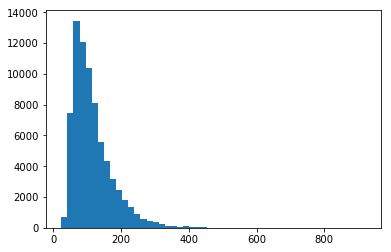

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths,bins=50)

In [103]:
#TODO testing
#doc_max_len=doc_min_len
print('Building model...')

def get_R(x):
    a, b = x.values()
    return K.dot(a, b)


embeddings = word2vec_embedding_layer(embeddings_path)

#embedding lookup
# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
# TODO: OOV embedding
input_query = Input(shape=(query_max_len,), dtype='int32', name='input_query')
input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
embedding_query = embeddings(input_query)  # (None, 6, 100)
embedding_doc = embeddings(input_doc)      # (None, 400, 100)

#shared linear projection
shared_lp = Dense(40,activation='linear')
query_output = shared_lp(embedding_query) # (None, 6, 40) 
doc_output = shared_lp(embedding_doc) #(None, 400, 40) 

#query: bi LSTM, lp -- implementation = 0 for CPU option, 1 or 2 for GPU
query_output = Bidirectional(LSTM(30, dropout=0.0, implementation=2, return_sequences=True, go_backwards=True,use_bias=True,unit_forget_bias=True,)\
                             ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
                            )(query_output) #(None, 6, 30) unless concat (None, 6, 60)  
query_output = Dense(50,activation='linear')(query_output) #(None, 50)

#doc: bi LSTM, lp
doc_output = Bidirectional(LSTM(30, dropout=0.0, implementation=2, return_sequences=True, go_backwards=True,use_bias=True,unit_forget_bias=True,)\
                             ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
                            )(doc_output) #(None, 6, 400) unless concat (None, 6, 800)  
doc_output = Dense(50,activation='linear')(doc_output) #(None, 50)

#2d product
#mt_input = batch_dot(query_output,doc_output,axes=None) #axes=[2,2])
#query_output = Flatten()(query_output)
#doc_output = Flatten()(doc_output)
#mt_input = multiply([query_output, doc_output])
#mt_input = dot([query_output, doc_output], axes=(0), normalize=False)  
dot_product_output = dot([query_output, doc_output], axes=(2), normalize=True)  
#output is (11, 6, 400), where did 50 go?
def func_expand_dims(x):
    return expand_dims(x, axis=-1)

def expand_dims_output_shape(input_shape):
    return (input_shape[0], input_shape[1],input_shape[2],1)

mt_input_1 = Lambda(func_expand_dims, expand_dims_output_shape)(dot_product_output)

#mt_input = dot([transpose(query_output), transpose(doc_output)], axes=(0), normalize=False)  
######################################

def state_layer_dot_prod(x):
    output_list=[]
#    output = dot([x[0], x[1]], axes=(2), normalize=False)  
    for i in range(50):
        print(i)
        print(x[0][i])
        print(x[1][i])
        #output = multiply([transpose(x[0][i]), x[1][i]])
        #output_list += output
        #output = dot([x[0][i], transpose(x[1][i])])
        #transpose(x[1][i])
    print(output_list)
    return output_list

def state_layer_dot_prod_shape(input_shape):
    'Merge output shape'
    shape = list(input_shape)
    #print(input_shape)
    #print(shape)
    outshape = (shape[0][0],shape[1][1],shape[0][1],shape[0][2])
    #print(outshape)
    return tuple(outshape)

######################################
#mt_input = Lambda(state_layer_dot_prod,output_shape=state_layer_dot_prod_shape)([transpose(query_output), transpose(doc_output)])
#mt_input = Lambda(state_layer_dot_prod,output_shape=state_layer_dot_prod_shape)([query_output, doc_output])

##TODO fix error:
#InvalidArgumentError: Input to reshape is a tensor with 4800 values, but the requested shape requires a multiple of 120000
#[[Node: reshape_23/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](lambda_40/dot_42/MatMul, reshape_23/Reshape/shape)]]
#mt_input = Reshape((doc_max_len, query_max_len,50))(mt_input)

#Append exact match channel
output_exact_match = Dense(doc_max_len,activation='linear')(input_exact_match)
mt_input_2 = Lambda(func_expand_dims, expand_dims_output_shape)(output_exact_match)
# mt_input = concatenate([mt_input_1,mt_input_2],axis=0)
mt_input = concatenate([mt_input_1,mt_input_2],axis=3)
#TODO testing
#mt_input = mt_input_1

# Conv layers 1
output1 = Conv2D(filters=18, kernel_size=(3, 3), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

output2 = Conv2D(filters=18, kernel_size=(3, 4), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

output3 = Conv2D(filters=18, kernel_size=(3, 5), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

# Conv layers 2
output1 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output1)

output2 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output2)

output3 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
                dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \
                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output3)

# Max pool layer
output1 = GlobalMaxPooling2D(data_format='channels_last')(output1)
output2 = GlobalMaxPooling2D(data_format='channels_last')(output2)
output3 = GlobalMaxPooling2D(data_format='channels_last')(output3)

# Merge
output_combined = add([output1,output2,output3])
#TODO testing
#output_combined = output1

# Final layer
#output = Dense(1,activation='sigmoid')(output_combined)
#categorical
output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform')(output_combined)


# build model
#model = Model([input_query], [query_output])
#model = Model([input_doc], [encoded_doc])
#model = Model([input_query,input_doc], [output1,output2,output3])
#model = Model([input_query,input_doc], [output_combined])
#model = Model([input_query,input_doc,input_exact_match], [query_output])
#model = Model([input_query,input_doc], [query_output,doc_output])
#model = Model([input_query,input_doc], [output])
#model = Model([input_query,input_doc,input_exact_match], [mt_input])
#model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
model = Model([input_query,input_doc,input_exact_match], [output])
#model = Model([input_query,input_doc,input_exact_match], [dot_product_output])


model.summary()

Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_query (InputLayer)         (None, 6)             0                                            
____________________________________________________________________________________________________
input_doc (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          multiple              10459100                                     
____________________________________________________________________________________________________
dense_1 (Dense)                  multiple              4040                                         
_________________________________________________________________________

In [104]:
# #TODO SSM
# #doc_max_len=doc_min_len
# print('Building model...')

# def get_R(x):
#     a, b = x.values()
#     return K.dot(a, b)


# embeddings = word2vec_embedding_layer(embeddings_path)

# #embedding lookup
# # TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
# # TODO: OOV embedding
# input_query = Input(shape=(query_max_len,), dtype='int32', name='input_query')
# input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
# input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
# input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
# embedding_query = embeddings(input_query)  # (None, 6, 100)
# embedding_doc = embeddings(input_doc)      # (None, 400, 100)

# #shared linear projection
# shared_lp = Dense(40,activation='linear')
# query_output = shared_lp(embedding_query) # (None, 6, 40) 
# doc_output = shared_lp(embedding_doc) #(None, 400, 40) 

# #query: bi LSTM, lp -- implementation = 0 for CPU option, 1 or 2 for GPU
# query_output = Bidirectional(LSTM(16, dropout=0.0, implementation=0, return_sequences=True, go_backwards=True)\
#                              ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
#                             )(query_output) #(None, 6, 30) unless concat (None, 6, 60)  
# query_output = Dense(50,activation='linear')(query_output) #(None, 50)

# #doc: bi LSTM, lp
# doc_output = Bidirectional(LSTM(64, dropout=0.0, implementation=0, return_sequences=True, go_backwards=True)\
#                              ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
#                             )(doc_output) #(None, 6, 400) unless concat (None, 6, 800)  
# doc_output = Dense(50,activation='linear')(doc_output) #(None, 50)

# #2d product
# #mt_input = batch_dot(query_output,doc_output,axes=None) #axes=[2,2])
# #query_output = Flatten()(query_output)
# #doc_output = Flatten()(doc_output)
# #mt_input = multiply([query_output, doc_output])
# #mt_input = dot([query_output, doc_output], axes=(0), normalize=False)  
# dot_product_output = dot([query_output, doc_output], axes=(2), normalize=True)  
# #output is (11, 6, 400), where did 50 go?
# def func_expand_dims(x):
#     return expand_dims(x, axis=-1)

# def expand_dims_output_shape(input_shape):
#     return (input_shape[0], input_shape[1],input_shape[2],1)

# mt_input_1 = Lambda(func_expand_dims, expand_dims_output_shape)(dot_product_output)


# # Merge
# #output_combined = add([output1,output2,output3])
# #TODO testing
# output1 = GlobalMaxPooling2D(data_format='channels_last')(mt_input_1)
# output_combined = output1


# # Final layer
# output = Dense(1,activation='sigmoid')(output_combined)
# #categorical
# #output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform', use_bias=True)(output_combined)


# # build model
# #model = Model([input_query], [query_output])
# #model = Model([input_doc], [encoded_doc])
# #model = Model([input_query,input_doc], [output1,output2,output3])
# #model = Model([input_query,input_doc], [output_combined])
# #model = Model([input_query,input_doc,input_exact_match], [query_output])
# #model = Model([input_query,input_doc], [query_output,doc_output])
# #model = Model([input_query,input_doc], [output])
# #model = Model([input_query,input_doc,input_exact_match], [mt_input])
# #model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
# model = Model([input_query,input_doc,input_exact_match], [output])


# model.summary()

In [105]:
# # from keras.layers import Input, merge
# # from keras.models import Model
# # import numpy as np

# # input_a = np.reshape([[1, 2, 3],[1, 2, 3],],[[1, 2, 3],[1, 2, 3]])
# # input_b = np.reshape([4, 5, 6], (1, 1, 3))

# # print(input_a)
# # print(input_b)
# # a = Input(shape=(1, 3))
# # b = Input(shape=(1, 3))

# # concat = merge([a, b], mode='concat', concat_axis=-1)
# # dot = merge([a, b], mode='dot', dot_axes=2)
# # cos = merge([a, b], mode='cos', dot_axes=2)

# # model_concat = Model(input=[a, b], output=concat)
# # model_dot = Model(input=[a, b], output=dot)
# # model_cos = Model(input=[a, b], output=cos)

# # print(model_concat.predict([input_a, input_b]))
# # print(model_dot.predict([input_a, input_b]))
# # print(model_cos.predict([input_a, input_b]))

# from keras import backend as K
# x_batch = K.ones(shape=(11, 6,50 ))
# y_batch = K.ones(shape=(11, 400,50))
# x_batch=K.batch_flatten(x_batch)
# y_batch=K.batch_flatten(y_batch)
# #xy_batch_dot = K.dot(transpose(y_batch),x_batch )#, axes=[0,0])
# xy_batch_dot = K.batch_dot(x_batch,y_batch, axes=[0,0])
# K.int_shape(xy_batch_dot)
# # K.int_shape(x_batch)
# # K.int_shape(y_batch)



In [106]:
optimizer = optimizers.Adam(lr=0.001)
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
x_query_train=np.array(query_word2vec_idx_list)[0:74067]
x_doc_train=np.array(doc_word2vec_idx_list)[0:74067]#[0:len(x_query_train)]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_train = sequence.pad_sequences(x_query_train, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_train = sequence.pad_sequences(x_doc_train, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

print('x_query_train shape:', x_query_train.shape)
print('x_doc_train shape:', x_doc_train.shape)
# print('x_query_test shape:', x_query_test.shape)
# print('x_doc_test shape:', x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
#y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
y_train=to_categorical(train_query_df['relevance_int'].as_matrix(),13)
# y_test=test_query_df['relevance_int'].as_matrix()
print('y_train shape:', y_train.shape)

Pad sequences (samples x time)
x_query_train shape: (74067, 6)
x_doc_train shape: (74067, 100)
y_train shape: (74067, 13)


In [108]:
len(max(query_word2vec_idx_list,key=len)) 
len(max(x_query_train,key=len)) 

6

In [109]:
x_doc_train[100]
y_train[100]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [110]:
exact_match_list=[]
for i in range(x_query_train.shape[0]):
    #print(i)
    c1=x_query_train[i]
    c2=x_doc_train[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list+=[(c1_inp == c2_inp).astype(int)]

In [111]:
exact_match_inp_train=np.array(exact_match_list)

In [112]:
exact_match_inp_train.shape

(74067, 6, 100)

In [113]:
print(train_query_df['search_term'][0])
print(product_df['product_title'][0])
print(x_query_train[i])
print(x_doc_train[i])
print(exact_match_inp_train[0])


angle bracket
simpson strong tie 12 gauge angle
[ 979 5124 1571 2864 2489    0]
[14620   848   473  9621 12823 14014 14380   794  5124  1571   129   324
   125     3  2864   490  9621 12823 14014 14380   794   583  5124  1571
  2192    93   414  3878   934   197   160   845  1595   977   690    16
  2608   264    43   270    66  1505   714    41    14    38    78   204
  1571   456  1387   510  3693  6596    49  5124   129  2608  1084    16
  2945   714    41   129   562  1270   138  2465   132   590 20849   745
   594     2  1571   129     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0

In [114]:
batch_size=200#2 #200
print('Train...')
hist=model.fit([x_query_train,x_doc_train,exact_match_inp_train], [y_train],
          batch_size=batch_size,
          epochs=10,
          validation_split=0.2,
          shuffle=True,
          verbose=2,
          #validation_data=[x_test, y_test])
         )


Train...
Train on 59253 samples, validate on 14814 samples
Epoch 1/10
141s - loss: 0.0630 - acc: 0.2727 - val_loss: 0.0658 - val_acc: 0.1402
Epoch 2/10
139s - loss: 0.0604 - acc: 0.3125 - val_loss: 0.0654 - val_acc: 0.1791
Epoch 3/10
136s - loss: 0.0595 - acc: 0.3270 - val_loss: 0.0643 - val_acc: 0.2153
Epoch 4/10
132s - loss: 0.0590 - acc: 0.3353 - val_loss: 0.0648 - val_acc: 0.2004
Epoch 5/10
130s - loss: 0.0585 - acc: 0.3397 - val_loss: 0.0634 - val_acc: 0.2357
Epoch 6/10
174s - loss: 0.0581 - acc: 0.3477 - val_loss: 0.0639 - val_acc: 0.2209
Epoch 7/10
133s - loss: 0.0577 - acc: 0.3531 - val_loss: 0.0642 - val_acc: 0.2322
Epoch 8/10
131s - loss: 0.0573 - acc: 0.3585 - val_loss: 0.0644 - val_acc: 0.2209
Epoch 9/10
131s - loss: 0.0569 - acc: 0.3637 - val_loss: 0.0634 - val_acc: 0.2393
Epoch 10/10
218s - loss: 0.0565 - acc: 0.3689 - val_loss: 0.0644 - val_acc: 0.2295


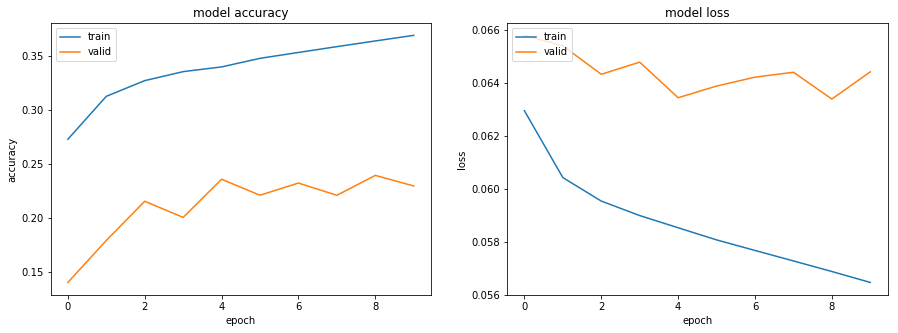

In [115]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [116]:
batch_size=200 #200
prediction=model.predict([x_query_train,x_doc_train,exact_match_inp_train],
          batch_size=batch_size,
         )

In [117]:
prediction.shape

(74067, 13)

In [118]:
prediction[0]

array([ 0.03997641,  0.00103513,  0.03729727,  0.00056168,  0.09402336,
        0.00057674,  0.14152159,  0.00077425,  0.21090187,  0.00030859,
        0.21045884,  0.00105888,  0.26150534], dtype=float32)

In [119]:
def pred2relevance(prediction):
    orig_labels = [ 1.  ,  1.25 , 1.33 , 1.5 ,  1.67,  1.75,  2. ,   2.25 , 2.33  ,2.5 ,  2.67  ,2.75 ,3.  ]
    new_labels= [ 0 , 1 , 2 , 3 , 4 , 5,  6 , 7 , 8,  9, 10 ,11, 12]
    orig_labels_prediction=[]
    for preds in prediction:
        #print(preds)
        max_idx=np.argmax(preds)
        orig_labels_prediction+=[orig_labels[max_idx]]
    return np.array(orig_labels_prediction)

In [120]:
orig_labels_prediction =  pred2relevance(prediction)

In [121]:
orig_labels_prediction[0]

3.0

In [122]:
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(train_query_df['relevance'].as_matrix(), orig_labels_prediction)**0.5

In [123]:
RMSE

0.59858401734415356

# print("Predict")
word_a = 'wood'#raw_input('First word: ')
if word_a not in word2idx:
    print('"%s" is not in the index' % word_a)
word_b = 'fan'#raw_input('Second word: ')
if word_b not in word2idx:
    print('"%s" is not in the index' % word_b)
output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
print('%f' % output)

In [124]:
test_df=test_private_df

In [125]:
test_query_sentences = []

print("Parsing sentences from search string")
for query in test_df["search_term"]:
    words,vocab = doc_to_wordlist(query, vocab, remove_stopwords=True)
    test_query_sentences += [words]
    

Parsing sentences from search string


In [126]:
len(test_query_sentences)

78419

In [127]:
test_query_word2vec_idx_list = query_sent2idx(test_query_sentences)

78419


In [128]:
test_joined_df=test_df.join(product_df.set_index('product_uid'), on='product_uid')

test_joined_doc_sentences=[]
for doc in test_joined_df['content']:
    words,vocab = doc_to_wordlist(doc, vocab, remove_stopwords=True)
    test_joined_doc_sentences += [words]
    
test_doc_word2vec_idx_list = query_sent2idx(test_joined_doc_sentences)

78419


In [129]:
x_query_test=np.array(test_query_word2vec_idx_list)[0:78419]
x_doc_test=np.array(test_doc_word2vec_idx_list)[0:78419]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

print('x_query_test shape:', x_query_test.shape)
print('x_doc_test shape:', x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
#y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
#y_test=to_categorical(train_query_df['relevance_int'].as_matrix(),13)
# y_test=test_query_df['relevance_int'].as_matrix()
#print('y_train shape:', y_train.shape)

Pad sequences (samples x time)
x_query_test shape: (78419, 6)
x_doc_test shape: (78419, 100)


In [130]:
exact_match_list_test=[]
for i in range(x_query_test.shape[0]):
    #print(i)
    c1=x_query_test[i]
    c2=x_doc_test[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list_test+=[(c1_inp == c2_inp).astype(int)]

exact_match_inp_test=np.array(exact_match_list_test)
exact_match_inp_test.shape

(78419, 6, 100)

In [131]:
print(test_query_df['search_term'][0])
print(x_query_test[0])
print(x_doc_test[0])
print(exact_match_inp_test[0])

90 degree bracket
[1867 5365  488    0    0    0]
[ 1867   399  1191    47   344   652  2876   196  1362  2016   106    65
  1271   886  1020  1867   399  1191    90   138   211  2876  1133   439
  5102    75    16   114  1716   544  1497   557   492  4695 11148   510
   404     8   544   423  2460     5  9686   509   321  1143    65   271
   358   311    49  1853   304   481  1180   521   801  1133   551   971
    11   883   544  2016  2051  2841   372  1355  3099   127   477  1362
  4957   886   399   326     6     3     6     3     2     2     4    28
    47   344    15   463   271   311   358   121  7029   761   702   173
     3     2     2     4]
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [132]:
batch_size=200 #200
test_prediction=model.predict([x_query_test,x_doc_test,exact_match_inp_test],
          batch_size=batch_size,
         )

In [133]:
test_prediction.shape

(78419, 13)

In [134]:
test_prediction[0]

array([  3.37288789e-02,   1.74667584e-04,   4.28897664e-02,
         3.60229242e-05,   9.47519615e-02,   1.39450101e-04,
         2.41705105e-01,   3.70574911e-04,   2.88672209e-01,
         6.37196354e-05,   1.96962118e-01,   1.92192630e-04,
         1.00313239e-01], dtype=float32)

In [135]:
test_orig_labels_prediction =  pred2relevance(test_prediction)

In [136]:
test_orig_labels_prediction[0]

2.3300000000000001

In [137]:
test_RMSE = mean_squared_error(test_df['relevance'].as_matrix(), test_orig_labels_prediction)**0.5
test_RMSE 

0.64102161798549973